# Inventory Monitoring at Distribution Centers
### AWS Machine Learning Nanodegree – Capstone Project
**Author: Narmina Yadullayeva**

This notebook describes several steps of AWS MLE nanodegree capstone project.

Kernel to use: 
- If from Sagemaker Instance => conda_pytorch_p39
- If from local - create custom environment

In [1]:
# TODO: Install any packages that you might need
!pip install smdebug

In [23]:
# TODO: Import any packages that you might need
import pprint
import os
import json
import boto3
import tqdm
import json
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd

import sagemaker
from botocore import UNSIGNED
from botocore.config import Config

import torch
import torchvision
from torchvision import datasets, models, transforms

from sklearn.model_selection import train_test_split 
import shutil
from collections import Counter
import numpy as np

To Do:

- Apply black / isort to all files
- Create a good Outline:

  - Data preparation. EDA
  - Experimentation
  - Deployment

# Step 1. Data Preparation

## 1.1. Download data

The cell below creates a folder called `train_data`, downloads data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)).

In [56]:
def download_and_arrange_data():
    
    df_meta = []
    s3_client = boto3.client('s3', region_name = "us-east-1", config=Config(signature_version=UNSIGNED))

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    meta_directory=os.path.join('metadata','metadata')
    if not os.path.exists(meta_directory):
        os.makedirs(meta_directory)
           
    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        for file_path in tqdm.tqdm(v):
            file_metadata = os.path.basename(file_path) 
            file_name=file_metadata.split('.')[0]+'.jpg'
            if os.path.exists(os.path.join(directory, file_name))==False:
                s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))
            if os.path.exists(os.path.join(meta_directory, file_metadata))==False:
                s3_client.download_file('aft-vbi-pds', os.path.join('metadata', file_metadata),
                                    os.path.join(meta_directory, file_metadata))
            f = open(os.path.join(meta_directory, file_metadata))
            data = json.load(f)
            data['filename']=file_name
            data['filepath']=os.path.join(directory, file_name)
            df_meta.append(data)
            
    df = pd.DataFrame(df_meta)
    df.drop(columns = 'image_fname',inplace=True)
    df.to_csv("metadata/metadata.csv", index=False)
    
download_and_arrange_data()

 16%|█████▍                           | 201/1228 [00:00<00:00, 2003.25it/s]

  7%|██▍                              | 169/2299 [00:00<00:01, 1688.43it/s]

  7%|██▍                              | 194/2666 [00:00<00:01, 1937.21it/s]

  8%|██▋                              | 193/2373 [00:00<00:01, 1920.71it/s]

 10%|███▎                             | 188/1875 [00:00<00:00, 1873.98it/s]

100%|████████████████████████████████| 1875/1875 [00:00<00:00, 1907.40it/s]


## 1.2. Dataset Overview and EDA

Amazon Fulfillment Centers are bustling hubs of innovation that allow Amazon to deliver millions of products to over 100 countries worldwide with the help of robotic and computer vision technologies. Amazon uses a random storage scheme where items are placed into accessible bins with available space, so the contents of each bin are random, rather than organized by specific product types. Thus, each bin image may show only one type of product or a diverse range of products. Occasionally, items are misplaced while being handled, so the contents of some bin images may not match the recorded inventory of that bin.

The Amazon Bin Image Dataset contains images and metadata from bins of a pod in an operating Amazon Fulfillment Center. The bin images in this dataset are captured as robot units carry pods as part of normal Amazon Fulfillment Center operations. Amazon Fulfillment Technologies has made the bin images available free of charge on Amazon S3 to encourage recognition research in a variety of areas, including counting generic items and learning from weakly-tagged data. Over 500,000 bin JPEG images and corresponding JSON metadata files describing items in the bin are available in the aft-vbi-pds S3 bucket in the us-east-1 AWS Region.

Images are located in the bin-images directory, and metadata for each image is located in the metadata directory. Images and their associated metadata share simple numerical unique identifiers. For example, the metadata for the image at https://aft-vbi-pds.s3.amazonaws.com/bin-images/523.jpg is found at https://aft-vbi-pds.s3.amazonaws.com/metadata/523.json.

The json object has two main keys. The `BIN_FCSKU_DATA` key returns the data about the image like height, width, weight etc. of the objects in the image while the `EXPECTED_QUANTITY` contains how many items are contained in the bin. 

Let's take a look at metadata:

In [57]:
meta_df = pd.read_csv("metadata/metadata.csv")
meta_df

,BIN_FCSKU_DATA,EXPECTED_QUANTITY,filename,filepath
0,"{'B00O0WRO08': {'asin': 'B00O0WRO08', 'height'...",1,100313.jpg,data/1/100313.jpg
1,"{'B00UO0UNOE': {'asin': 'B00UO0UNOE', 'height'...",1,09915.jpg,data/1/09915.jpg
2,"{'B003JKT3DS': {'asin': 'B003JKT3DS', 'height'...",1,103299.jpg,data/1/103299.jpg
3,"{'B00NG87OIY': {'asin': 'B00NG87OIY', 'height'...",1,00710.jpg,data/1/00710.jpg
4,"{'B00U2UZ40Y': {'asin': 'B00U2UZ40Y', 'height'...",1,05397.jpg,data/1/05397.jpg
...,...,...,...,...
10436,"{'0783811691': {'asin': '0783811691', 'height'...",5,100598.jpg,data/5/100598.jpg
10437,"{'0061782661': {'asin': '0061782661', 'height'...",5,1042.jpg,data/5/1042.jpg
10438,"{'B0161TCR9A': {'asin': 'B0161TCR9A', 'height'...",5,07628.jpg,data/5/07628.jpg
10439,"{'B00DVQRJEK': {'asin': 'B00DVQRJEK', 'height'...",5,103667.jpg,data/5/103667.jpg


Checking for class imbalance:

In [32]:
meta_df['EXPECTED_QUANTITY'].value_counts().sort_values()

1    1228
5    1875
2    2299
4    2373
3    2666
Name: EXPECTED_QUANTITY, dtype: int64

Let's take a look at metadata frin sample image:

In [33]:
image_meta = eval(meta_df.sample()['BIN_FCSKU_DATA'].values[0])
print(image_meta)

{'B000ED9L6C': {'asin': 'B000ED9L6C', 'height': {'unit': 'IN', 'value': 3.99999999592}, 'length': {'unit': 'IN', 'value': 9.699999990105999}, 'name': "Bob's Red Mill Raw Shelled Sunflower Seeds (Kernels Only), 20-ounce (Pack of 4) (Package May Vary)", 'normalizedName': "(Pack of 4) Bob's Red Mill Raw Shelled Sunflower Seeds (Kernels Only), 20-ounce (Package May Vary)", 'quantity': 2, 'weight': {'unit': 'pounds', 'value': 4.95}, 'width': {'unit': 'IN', 'value': 8.199999991636}}, 'B00H2B4H2M': {'asin': 'B00H2B4H2M', 'height': {'unit': 'IN', 'value': 3.599999996328}, 'length': {'unit': 'IN', 'value': 10.599999989188}, 'name': 'Remington PG6025 All-in-1 Lithium Powered Grooming Kit, Black', 'normalizedName': 'Remington PG6025 All-in-1 Lithium Powered Grooming Kit, Black', 'quantity': 1, 'weight': {'unit': 'pounds', 'value': 1.0}, 'width': {'unit': 'IN', 'value': 6.599999993268}}, 'B01BI5PCJY': {'asin': 'B01BI5PCJY', 'height': {'unit': 'IN', 'value': 2.7999999971439995}, 'length': {'unit': 

Let's take a look at random image of the bin and its contents:

1ea BigMouth Inc Sperm Donor Mug, White
2ea XTREME SHAPER SLIMMING BELT (BLACK SMALL)


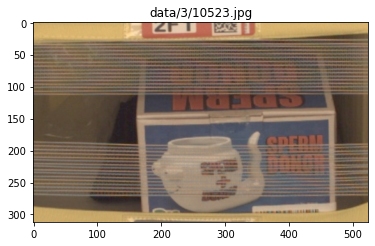

In [34]:
sample_image = meta_df.sample()
file_path, bin_class = sample_image[['filepath','EXPECTED_QUANTITY']].values[0]
image_meta = eval(sample_image['BIN_FCSKU_DATA'].values[0])
for obj in image_meta.keys():
    print(str(image_meta[obj]['quantity']) + 'ea ' + image_meta[obj]['name'])
    
img = mpimg.imread(file_path)
plt.imshow(img)
plt.title(str(file_path))
plt.show()

## 1.3. Data Split

Let us do train-test split and save it to s3:

In [58]:
def split_and_save_data(meta_df, output_path ="train_data", test_size = 0.20):
    
    train, test = train_test_split(meta_df, test_size=test_size, stratify=meta_df['EXPECTED_QUANTITY'], random_state = 0) 
    
    for old_file_path, file_name, qty in train[['filepath','filename',"EXPECTED_QUANTITY"]].values:
        new_file_path = os.path.join(output_path,'train', str(qty))
        if not os.path.exists(new_file_path):
            os.makedirs(new_file_path)
        shutil.copyfile(old_file_path, os.path.join(new_file_path,file_name))
                        
    for old_file_path, file_name, qty in test[['filepath','filename',"EXPECTED_QUANTITY"]].values:
        new_file_path = os.path.join(output_path,'test', str(qty))
        if not os.path.exists(new_file_path):
            os.makedirs(new_file_path)
        shutil.copyfile(old_file_path, os.path.join(new_file_path,file_name))
    
    train["new_filepath"] = train["filepath"].apply(lambda x: 'train_data/train/'+''.join(x.split("/")[1:]))
    test["new_filepath"] = test["filepath"].apply(lambda x: 'train_data/test/'+'/'.join(x.split("/")[1:]))

    train.to_csv(os.path.join(output_path,'train_meta.csv'))
    test.to_csv(os.path.join(output_path,'test_meta.csv'))                   
        
    return train, test

In [59]:
train, test = split_and_save_data(meta_df, output_path ="train_data", test_size = 0.20)
train

,BIN_FCSKU_DATA,EXPECTED_QUANTITY,filename,filepath,new_filepath
7161,"{'B0044ZSMOI': {'asin': 'B0044ZSMOI', 'height'...",4,00680.jpg,data/4/00680.jpg,train_data/train/400680.jpg
8069,"{'B00BMWMS1Y': {'asin': 'B00BMWMS1Y', 'height'...",4,00452.jpg,data/4/00452.jpg,train_data/train/400452.jpg
8916,"{'B00SPZPAAW': {'asin': 'B00SPZPAAW', 'height'...",5,101550.jpg,data/5/101550.jpg,train_data/train/5101550.jpg
8200,"{'B001LQY1X4': {'asin': 'B001LQY1X4', 'height'...",4,103807.jpg,data/4/103807.jpg,train_data/train/4103807.jpg
8126,"{'B000QRFOT4': {'asin': 'B000QRFOT4', 'height'...",4,04564.jpg,data/4/04564.jpg,train_data/train/404564.jpg
...,...,...,...,...,...
6382,"{'111864767X': {'asin': '111864767X', 'height'...",4,102319.jpg,data/4/102319.jpg,train_data/train/4102319.jpg
2650,"{'B00H4Y1Q9E': {'asin': 'B00H4Y1Q9E', 'height'...",2,101384.jpg,data/2/101384.jpg,train_data/train/2101384.jpg
818,"{'B00SYII548': {'asin': 'B00SYII548', 'height'...",1,07598.jpg,data/1/07598.jpg,train_data/train/107598.jpg
4873,"{'B003QVIWEQ': {'asin': 'B003QVIWEQ', 'height'...",3,01500.jpg,data/3/01500.jpg,train_data/train/301500.jpg


In [60]:
test

,BIN_FCSKU_DATA,EXPECTED_QUANTITY,filename,filepath,new_filepath
3649,"{'B00XDYPXH0': {'asin': 'B00XDYPXH0', 'height'...",3,03885.jpg,data/3/03885.jpg,train_data/test/3/03885.jpg
24,"{'B00004SGFP': {'asin': 'B00004SGFP', 'height'...",1,102311.jpg,data/1/102311.jpg,train_data/test/1/102311.jpg
7439,"{'B0018G4ZEW': {'asin': 'B0018G4ZEW', 'height'...",4,06982.jpg,data/4/06982.jpg,train_data/test/4/06982.jpg
8414,"{'B00802F244': {'asin': 'B00802F244', 'height'...",4,102651.jpg,data/4/102651.jpg,train_data/test/4/102651.jpg
765,"{'B005688T5E': {'asin': 'B005688T5E', 'height'...",1,104143.jpg,data/1/104143.jpg,train_data/test/1/104143.jpg
...,...,...,...,...,...
8615,"{'B004M8WFP4': {'asin': 'B004M8WFP4', 'height'...",5,08079.jpg,data/5/08079.jpg,train_data/test/5/08079.jpg
10035,"{'B006M64H7S': {'asin': 'B006M64H7S', 'height'...",5,02243.jpg,data/5/02243.jpg,train_data/test/5/02243.jpg
8396,"{'B00LOSLRAO': {'asin': 'B00LOSLRAO', 'height'...",4,01464.jpg,data/4/01464.jpg,train_data/test/4/01464.jpg
7489,"{'B00SNLRQT6': {'asin': 'B00SNLRQT6', 'height'...",4,03374.jpg,data/4/03374.jpg,train_data/test/4/03374.jpg


## 1.4. Defining preprocessing steps

Let's calculate mean and standard deviation for our train and test dataset

In [63]:
training_data_path = './train_data/train/'
test_data_path = './train_data/test/'

In [125]:
# might need to experiment further with different image size and batch size
image_size = 224
batch_size=32

In [88]:
train_transform = transforms.Compose([    
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor()   
])

train_dataset = torchvision.datasets.ImageFolder(root=training_data_path, transform=train_transform)
train_dataset

Dataset ImageFolder
    Number of datapoints: 8352
    Root location: ./train_data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [91]:
# calculating approximation for mean and std
def get_mean_and_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
        
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std

In [92]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False) 

train_mean, train_std = get_mean_and_std(train_loader)
train_mean, train_std

(tensor([0.5232, 0.4421, 0.3526]), tensor([0.1355, 0.1195, 0.0900]))

In [93]:
# loading dataset into tv dataset object

train_transform = transforms.Compose([    
        transforms.Resize((image_size,image_size)),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(10),   
        transforms.ToTensor(),    
        transforms.Normalize(torch.Tensor(train_mean), torch.Tensor(train_std))
    ])

test_transform = transforms.Compose([    
        transforms.Resize((image_size,image_size)),     
        transforms.ToTensor(),    
        transforms.Normalize(torch.Tensor(train_mean), torch.Tensor(train_std))
    ])

train_dataset = torchvision.datasets.ImageFolder(root=training_data_path, transform=train_transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_data_path, transform=test_transform)

train_dataset

Dataset ImageFolder
    Number of datapoints: 8352
    Root location: ./train_data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=tensor([0.5232, 0.4421, 0.3526]), std=tensor([0.1355, 0.1195, 0.0900]))
           )

In [106]:
# let's check whether we did everything right e.g. what's distribution of targets in train / test
def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val]

5


In [ ]:
# checking train dataset
counter_object = Counter(train_dataset.targets)
keys = counter_object.keys()
num_values = len(keys)
print(num_values)

classes_num = {}
for key in counter_object.keys():
    classes_num[get_keys_from_value(train_dataset.class_to_idx,key)[0]] = counter_object[key]
print(classes_num)

In [109]:
# test dataset
counter_object = Counter(test_dataset.targets)
keys = counter_object.keys()
num_values = len(keys)
print(num_values)

classes_num = {}
for key in counter_object.keys():
    classes_num[get_keys_from_value(test_dataset.class_to_idx,key)[0]] = counter_object[key]
print(classes_num)

{'1': 246, '2': 460, '3': 533, '4': 475, '5': 375}

In [118]:
print(classes_num["1"]/meta_df['EXPECTED_QUANTITY'].value_counts()[1])
print(classes_num["2"]/meta_df['EXPECTED_QUANTITY'].value_counts()[2])
print(classes_num["3"]/meta_df['EXPECTED_QUANTITY'].value_counts()[3])
print(classes_num["4"]/meta_df['EXPECTED_QUANTITY'].value_counts()[4])
print(classes_num["5"]/meta_df['EXPECTED_QUANTITY'].value_counts()[5])

0.2003257328990228
0.20008699434536756
0.19992498124531133
0.2001685630004214
0.2


In [98]:
# let's visualize sample images after applying data transformation
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=12, shuffle=True) 
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images,nrow = 3)
    plt.figure(figsize = (11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ',labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([4, 3, 1, 2, 2, 0, 4, 1, 0, 3, 4, 3])


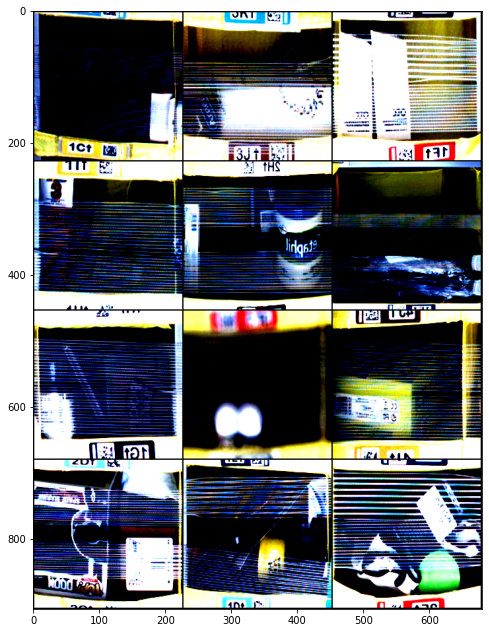

In [99]:
show_transformed_images(train_dataset)

# Step 2. Experimentation
## 2.1. Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

### 2.1.1. Training Locally

In [122]:
!python train_model.py --data-path "train_data" --model-type "resnet50"

[2023-04-09 13:29:20.559 Narminas-MBP:27213 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-09 13:29:20.640 Narminas-MBP:27213 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
--- Running on Device mps ---
--- Loading and Transforming Dataset ---
--- num_classes: 5 ---
--- Initializing pre-trained model ---
/Users/narmina/.pyenv/versions/env-3.8.10/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/narmina/.pyenv/versions/env-3.8.10/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_W

## Testing trained model locally

Let's pass some image from test dataset to our model and evaluate predictions.

First, let's declare a couple of auxilary functions to load the model and make predictions.

In [182]:
def model_fn(model_dir):
    model = torch.load(os.path.join(model_dir, "model.pth"), map_location=device)
    model.eval()
    model.to(device)
    return model

def input_fn(iobytes):
    img = Image.open(iobytes)
    
    preprocess = transforms.Compose(
        [
            transforms.Resize((image_size,image_size)),
            transforms.ToTensor(),
            transforms.Normalize(train_mean, train_std),
        ]
    )
    input_tensor = preprocess(img)
    input_batch = input_tensor.unsqueeze(0)  # create a mini-batch as expected by the model
    return input_batch.to(device)


def predict_fn(image, model):
    image = input_fn(image)
    return model(image)

In [183]:
# Loading model

device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu")
print('Device: ',device)
predictor = model_fn('.')

Device:  mps


train_data/test/3/04382.jpg
[[-0.58978057  0.61877054  0.6425688   0.34781188 -0.33548206]]
Most likely class: 3


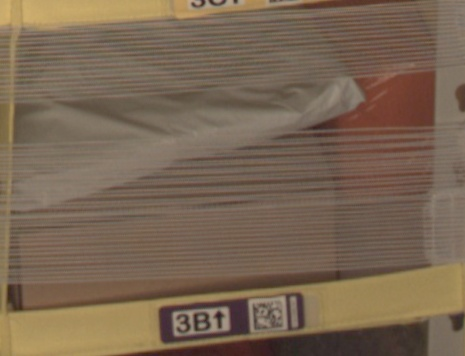

In [185]:
from torch import Tensor
from PIL import Image
import io

sample_test_image = test.sample()['new_filepath'].values[0]
print(sample_test_image)

f = open(sample_test_image, "rb")

prediction = predict_fn(f,predictor).cpu().detach().numpy()
print(prediction)
most_likely_class_num = np.argmax(prediction)
most_likely_class = get_keys_from_value(train_dataset.class_to_idx,most_likely_class_num)[0]

print("Most likely class: {}".format(most_likely_class))

image = Image.open(sample_test_image)
image

train_data/test/2/04736.jpg
[[-1.0299987  -0.23244414  0.07640271  0.47541475  0.49334857]]
Most likely class: 5


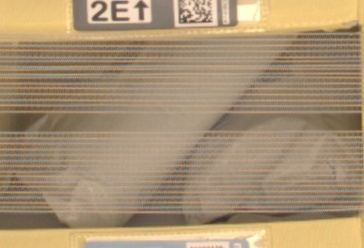

In [180]:
from torch import Tensor
from PIL import Image
import io

sample_test_image = test.sample()['new_filepath'].values[0]
print(sample_test_image)

f = open(sample_test_image, "rb")

prediction = predict_fn(f,predictor).cpu().detach().numpy()
print(prediction)
most_likely_class_num = np.argmax(prediction)
most_likely_class = get_keys_from_value(train_dataset.class_to_idx,most_likely_class_num)[0]

print("Most likely class: {}".format(most_likely_class))

image = Image.open(sample_test_image)
image

train_data/test/2/10502.jpg
[[-0.91381234  0.43221173  0.21529144  0.39633146  0.06045884]]
Most likely class: 2


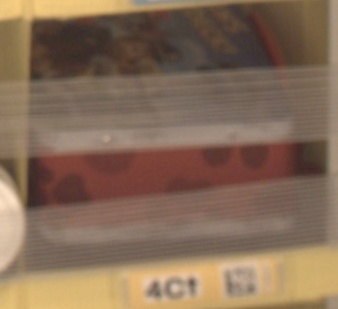

In [181]:
from torch import Tensor
from PIL import Image
import io

sample_test_image = test.sample()['new_filepath'].values[0]
print(sample_test_image)

f = open(sample_test_image, "rb")

prediction = predict_fn(f,predictor).cpu().detach().numpy()
print(prediction)
most_likely_class_num = np.argmax(prediction)
most_likely_class = get_keys_from_value(train_dataset.class_to_idx,most_likely_class_num)[0]

print("Most likely class: {}".format(most_likely_class))

image = Image.open(sample_test_image)
image

### 2.1.2. Training via AWS Sagemaker

#### Downloading dataset to S3 bucket

In [19]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [20]:
prefix = "capstone_project/data"
data_path = "train_data"

## this lines are commented out as I've downloaded this to s3 already
inputs = sagemaker_session.upload_data(path=data_path, bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-976414713425/capstone_project/data


In [8]:
## saved it here 
inputs = "s3://sagemaker-us-east-1-976414713425/capstone_project/data"

### Running training job

In [ ]:
# Declaring model training hyperparameter.
hyperparameters = {"epochs": "10", "batch-size": "64", "lr": "0.01", "momentum": "0.5", "image-size": "224"}

In [ ]:
#TODO: Create your training estimator
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

hyperparameters = {"epochs": "10", "batch-size": "64", "lr": "0.01", "momentum": "0.5", "image-size": "224"}

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="sagemaker-script-mode",
    role=get_execution_role(),
    instance_count=1,
    instance_type = "ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
)


In [ ]:
# TODO: Fit your estimator
estimator.fit({"training": inputs}, wait=True)

### 2.2. Hyperparameter Tuning

In this section I will be trying several hyperparameters configuration to find the best fitted model. In order to do that, I've created `hpo.py` script which reflects all the steps I've been using for training. 

In [126]:
import sagemaker
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

from sagemaker.pytorch import PyTorch

In [ ]:
# initializing estimator object

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type = "ml.g4dn.xlarge"
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
    "momentum": ContinuousParameter(0.5, 0.9),
}

objective_metric_name = "Average test accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "Average test accuracy", "Regex": "Epoch test accuracy: ([0-9\\.]+)"}]

In [ ]:
# TODO: Fit your estimator

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=5,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

tuner.fit({"training": inputs})

In [ ]:
from sagemaker.tuner import HyperparameterTuner
tuner = HyperparameterTuner.attach("pytorch-training-230218-1340")

In [ ]:
# get the best estimators
best_estimator = tuner.best_estimator()

# get the hyperparameters of the best trained model
best_estimator.hyperparameters()

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [ ]:
# TODO: Set up debugging and profiling rules and hooks

In [ ]:
# TODO: Create and fit an estimator

In [ ]:
# TODO: Plot a debugging output.

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [ ]:
# TODO: Display the profiler output

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [ ]:
# TODO: Deploy your model to an endpoint

In [ ]:
# TODO: Run an prediction on the endpoint

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done

### Cheaper Training and Cost Analysis
**TODO:** Can you perform a cost analysis of your system and then use spot instances to lessen your model training cost?

In [ ]:
# TODO: Cost Analysis

In [ ]:
# TODO: Train your model using a spot instance

### Multi-Instance Training
**TODO:** Can you train your model on multiple instances?

In [ ]:
# TODO: Train your model on Multiple Instances